In [1]:
import pandas as pd
import warnings
import requests, zipfile, io, os, re
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
warnings.filterwarnings('ignore')

In [2]:
# download file from url, extract it and store it in the dest_folder
def download_and_extract(url, dest_folder):
  r = requests.get(url)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall(dest_folder)

In [3]:
# define folders and urls
healthy_path = './healthy'
healthy_url = 'http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewHealthy/Signal.zip'
parkinson_path = './parkinson'
parkinson_url = 'http://wwwp.fc.unesp.br/~papa/pub/datasets/Handpd/NewPatients/Signal.zip'

In [4]:
download_and_extract(healthy_url, healthy_path)

In [5]:
download_and_extract(parkinson_url, parkinson_path)

In [6]:
# actual downloaded signals
healthy_signals = f'{healthy_path}/Signal/'
parkinson_signals = f'{parkinson_path}/Signal/'
healthy = []
parkinson = []

In [7]:
for filename in os.listdir(healthy_signals):
  if re.search('sigMea', filename) is not None:
    df = pd.read_csv(healthy_signals + filename, sep='\s+', header=None, comment='#')
    healthy.append(df)

for filename in os.listdir(parkinson_signals):
 if re.search('sigMea', filename) is not None:
    df = pd.read_csv(parkinson_signals + filename, sep='\s+', header=None, comment='#')
    parkinson.append(df)


In [8]:
def preprocess(X, y):
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
  scaler = StandardScaler()
  X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
  X_valid = scaler.transform(X_valid.reshape(-1, X_valid.shape[-1])).reshape(X_valid.shape)
  return X_train, X_valid, y_train, y_valid

In [9]:
def create_dataset(healthy, parkinson, seq):
  X = []
  y = []

  # healthy signals
  for df in healthy:
    count = len(df.index) // seq
    for i in range(count):
      X.append((df.iloc[i * seq : (i + 1) * seq]).to_numpy())
      y.append(0)

  # parkinson signals
  for df in parkinson:
    count = len(df.index) // seq
    for i in range(count):
      X.append((df.iloc[i * seq : (i + 1) * seq]).to_numpy())
      y.append(1)

  return np.array(X), np.array(y)


In [10]:
def train_model(X_train, X_valid, y_train, y_valid):
  model = keras.models.Sequential([
  keras.layers.GRU(128, return_sequences=True, input_shape=(X_train.shape[1], 6)),
  keras.layers.GRU(128),
  keras.layers.Dense(1, activation="sigmoid")
  ])

  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
  model.fit(X_train, y_train, epochs = 100, batch_size = 64,validation_data=(X_valid, y_valid))
  return model.evaluate(X_valid, y_valid)



In [11]:
sequence_list = [320,340,360,380]
loss = []
accuracy = []


for sequence in sequence_list:
  X, y = create_dataset(healthy, parkinson, sequence)
  X_train, X_valid, y_train, y_valid = preprocess(X, y)
  curr_loss, curr_accuracy = train_model(X_train, X_valid, y_train, y_valid)
  
  loss.append(curr_loss)
  accuracy.append(curr_accuracy)
  print(curr_loss, curr_accuracy)



Epoch 1/100
160/160 [==============================] - 6s 37ms/step - loss: 0.5786 - accuracy: 0.6933 - val_loss: 0.5484 - val_accuracy: 0.7202
Epoch 2/100
160/160 [==============================] - 5s 32ms/step - loss: 0.5142 - accuracy: 0.7557 - val_loss: 0.5072 - val_accuracy: 0.7608
Epoch 3/100
160/160 [==============================] - 5s 32ms/step - loss: 0.4740 - accuracy: 0.7804 - val_loss: 0.4505 - val_accuracy: 0.7999
Epoch 4/100
160/160 [==============================] - 5s 32ms/step - loss: 0.4314 - accuracy: 0.8043 - val_loss: 0.4372 - val_accuracy: 0.8054
Epoch 5/100
160/160 [==============================] - 5s 32ms/step - loss: 0.4042 - accuracy: 0.8184 - val_loss: 0.3939 - val_accuracy: 0.8195
Epoch 6/100
160/160 [==============================] - 5s 32ms/step - loss: 0.3733 - accuracy: 0.8319 - val_loss: 0.3614 - val_accuracy: 0.8347
Epoch 7/100
160/160 [==============================] - 5s 33ms/step - loss: 0.3413 - accuracy: 0.8457 - val_loss: 0.3730 - val_accuracy:

In [12]:
loss

[0.45127370953559875,
 0.490232914686203,
 0.3210678994655609,
 0.44209399819374084]

In [13]:
accuracy

[0.9296600222587585, 0.9331395626068115, 0.921214759349823, 0.9336118698120117]

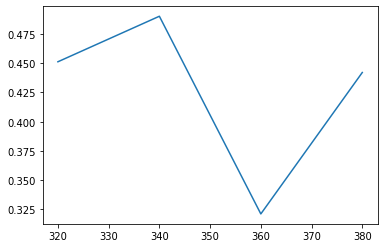

In [14]:
plt.plot(sequence_list, loss)

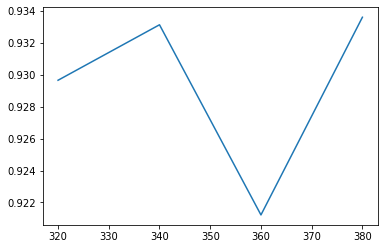

In [15]:
plt.plot(sequence_list, accuracy)